## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
#clear all variables
%reset

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

#%matplotlib qt


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Camera Calibration using chessboard images

In [4]:
# function to calibrate the camera and return distortion matrix
def cal_camera():
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    #print('total images are :', images)
    #print(type(images), size(images))
    # Step through the list and search for chessboard corners
    
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        #print(gray.shape, gray.shape[0], gray.shape[1])
    
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(50)

    
    cv2.destroyAllWindows()
    
    # Calibrate camera and apply distortion matrix to test images
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return mtx,dist

In [5]:
# Calibrate camera and apply distortion matrix to test images
mtx, dist = cal_camera()

## Undistort chessboard images using the distortion matrix

In [6]:
def undistort_images(img, cam_mtx, cam_dist):
    
    dst = cv2.undistort(img, cam_mtx, cam_dist, None, cam_mtx)
    
    return dst

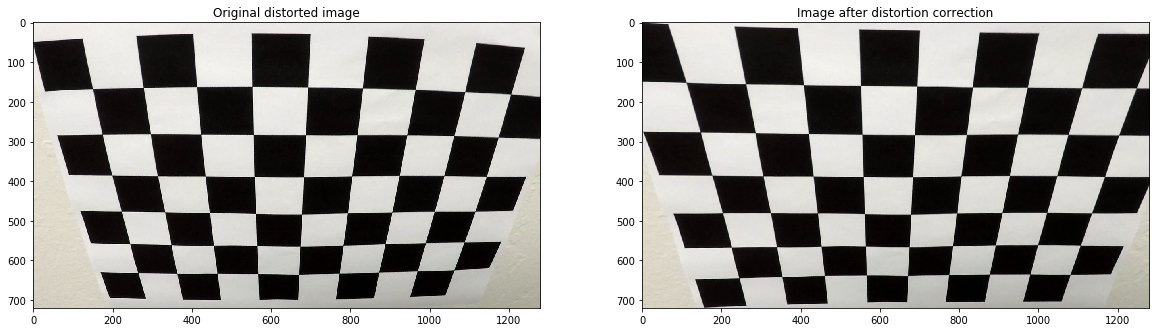

In [9]:
testfname = './camera_cal/calibration2.jpg'
test_img = cv2.imread(testfname)

dst = undistort_images(test_img, mtx, dist)

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title('Original distorted image')
plt.imshow(test_img[:,:,::-1])
plt.subplot(1,2,2)
plt.title('Image after distortion correction')
plt.imshow(dst[:,:,::-1])

## Undistort a road image

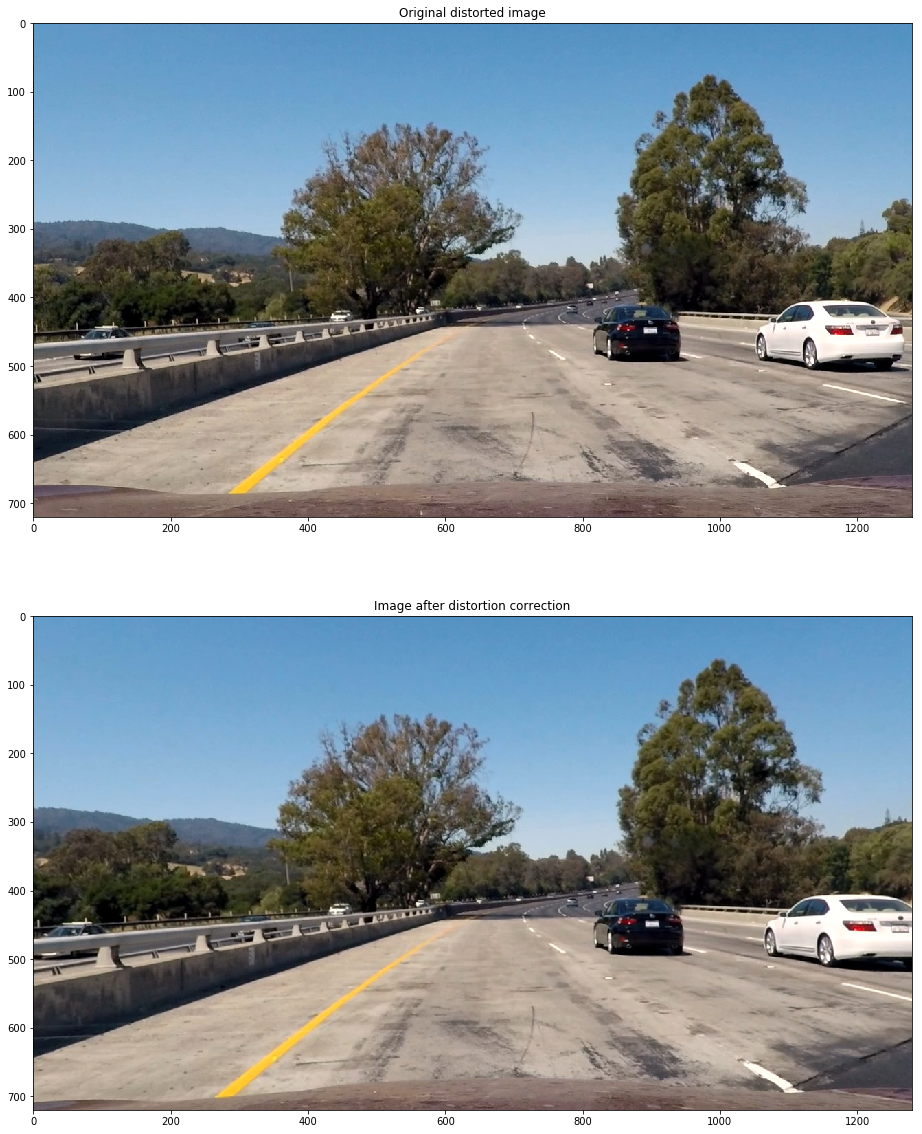

In [10]:
testfname = './test_images/test1.jpg'
test_img = cv2.imread(testfname)

dst = undistort_images(test_img, mtx, dist)

plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
plt.title('Original distorted image')
plt.imshow(test_img[:,:,::-1])
plt.subplot(2,1,2)
plt.title('Image after distortion correction')
plt.imshow(dst[:,:,::-1])

## Apply thresholding 
Binary thresholding on Sobel gradient, Sobel Mag and dir, and S-channel Color  

In [11]:
# Apply binary thresholding
def bin_threshold_pipeline(image, s_thresh=(170, 255), sx_thresh=(20, 100), smag_thresh=(20,100), sdir_thresh=(0.7,1.3)):
    
    img = np.copy(image)
    img = img[:,:,::-1]

    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
      
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel_x = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel_x)
    sxbinary[(scaled_sobel_x >= sx_thresh[0]) & (scaled_sobel_x <= sx_thresh[1])] = 1

    # Sobel y
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1) # Take the derivative in x
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel_y = np.uint8(255*abs_sobely/np.max(abs_sobely))

    # Sobel magnitude and direction
    sobel_mag = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel_mag = np.uint8(255*sobel_mag/np.max(sobel_mag))

    sobel_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

    # Sobel magnitude and direction threshold
    smagbinary = np.zeros_like(scaled_sobel_mag)
    smagbinary[(scaled_sobel_mag >= smag_thresh[0]) & (scaled_sobel_mag <= smag_thresh[1])] = 1

    sdirbinary = np.zeros_like(sobel_dir)
    sdirbinary[(sobel_dir >= sdir_thresh[0]) & (sobel_dir <= sdir_thresh[1])] = 1

    # Threshold y gradient
    sybinary = np.zeros_like(scaled_sobel_y)
    sybinary[(scaled_sobel_y >= sx_thresh[0]) & (scaled_sobel_y <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1) | ((smagbinary == 1) & (sdirbinary == 1))] = 1

    return color_binary, combined_binary

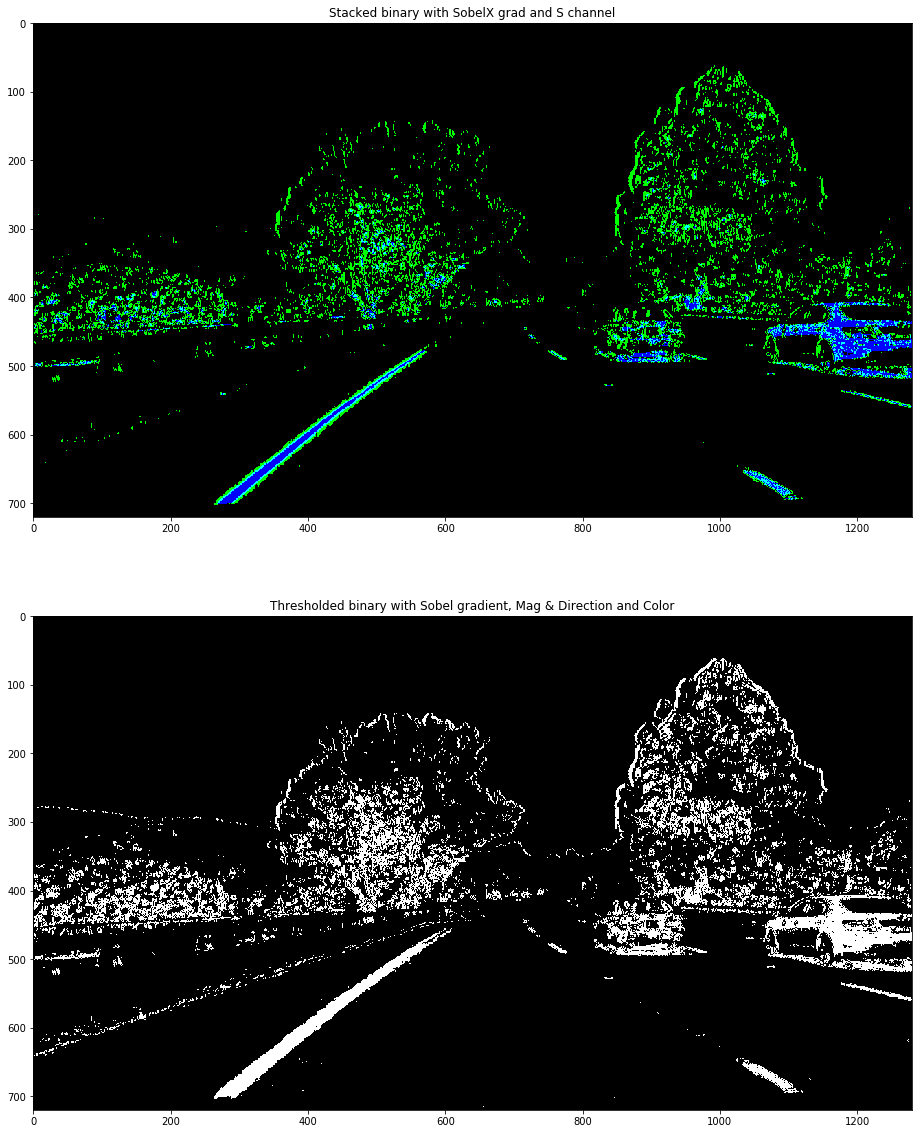

In [12]:
#Run the pipeline
result_color_bin, result_combined_bin = bin_threshold_pipeline(dst)

plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
plt.title('Stacked binary with SobelX grad and S channel')
plt.imshow(result_color_bin)
plt.subplot(2,1,2)
plt.title('Thresholded binary with Sobel gradient, Mag & Direction and Color')
plt.imshow(result_combined_bin,cmap='gray')

## Perspective transform

In [13]:
def warp(image):
    
    image_size = (image.shape[1], image.shape[0])
    
    src = np.float32(
        [[570, 450],
         [730, 450],
         [-100, 720],
         [1380, 720]])
    
    dst = np.float32(
        [[100, 0],
         [1180,0],
         [100, 720],
         [1180, 720]])
 
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    
    return warped, Minv

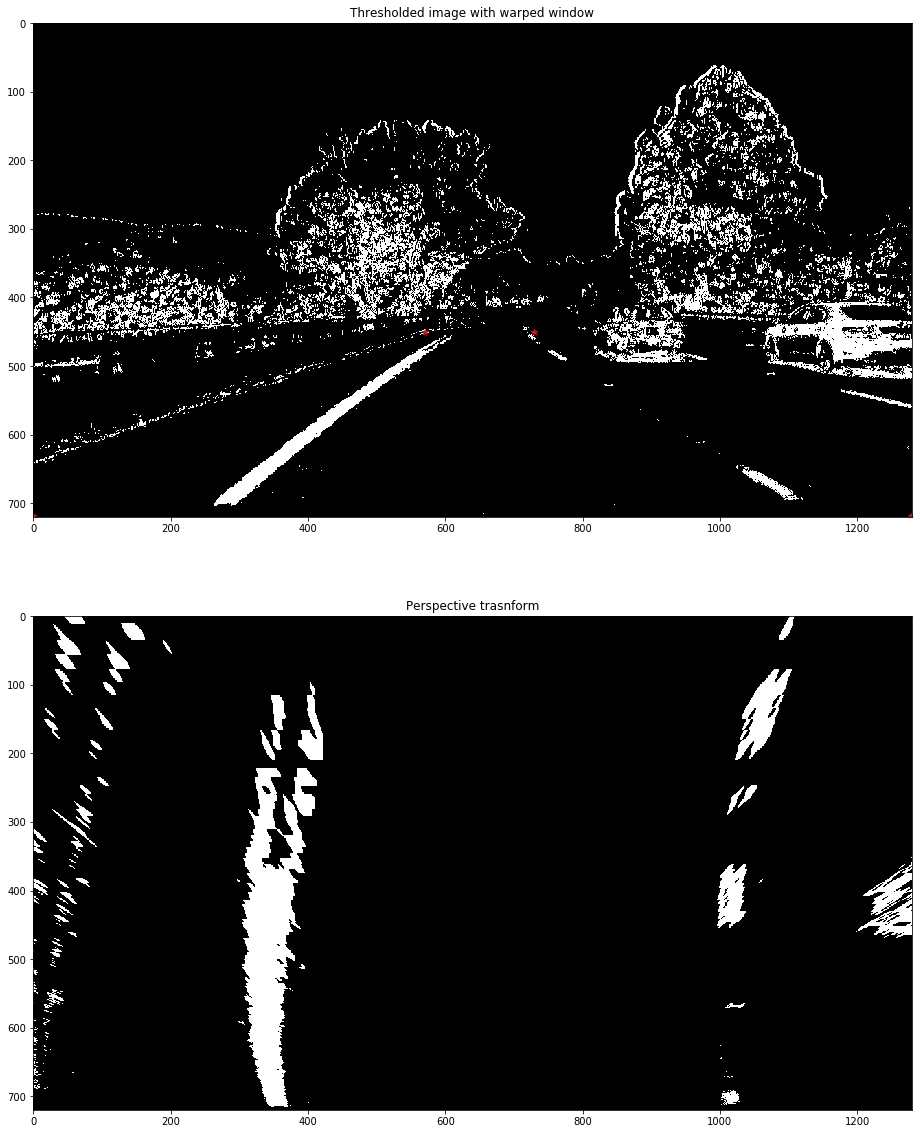

In [14]:
plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
plt.title('Thresholded image with warped window')
plt.imshow(result_combined_bin, cmap='gray')

plt.plot(570,450,'r*')
plt.plot(730,450,'r*')
plt.plot(0,719,'r*')
plt.plot(1279,719,'r*')

warped_img, Minv = warp(result_combined_bin)

plt.subplot(2,1,2)
plt.title('Perspective trasnform')
plt.imshow(warped_img, cmap='gray')

## Detecting lanes and curve fit 

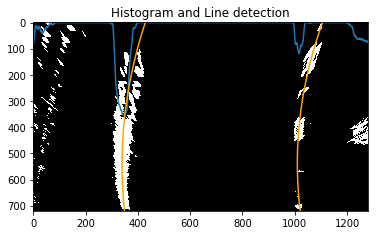

In [30]:
histogram = np.sum(warped_img[warped_img.shape[0]/2:,:], axis=0)
out_img = np.dstack((warped_img, warped_img, warped_img))*255

midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[100:midpoint]) + 100
rightx_base = np.argmax(histogram[midpoint:]) + midpoint 

polyfit_img, left_fitx, right_fitx, ploty, adjust_bool = poly_fit_rimage(warped_img)
filled_img = filled_image(test_img, warped_img, Minv, left_fitx, right_fitx, ploty)

#print(histogram[midpoint:], midpoint, leftx_base, rightx_base)
plt.plot(histogram)
plt.imshow(warped_img, cmap='gray')
plt.title('Histogram and Line detection')
plt.plot(left_fitx, ploty, color='orange')
plt.plot(right_fitx, ploty, color='orange')


## Detect lanes and curve fit
    1) Detect using histogram to initiate search and then windowing 
    2) Curve Fit
    3) Error checking and correction
        * Check if road width is within expected range; apply correction if not
        * Apply correction if 3 windows from either end of the image are empty, polyfit does not do a good job 

In [31]:
def poly_fit_rimage(warped_img):

    global avg_road_width
    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(warped_img.shape[0]/nwindows)
    
    histogram = np.sum(warped_img[warped_img.shape[0]/2:,:], axis=0)
    out_img = np.dstack((warped_img, warped_img, warped_img))*255
    
    end_margin_px = 100
    #Dont start search for the entire image, look within the perspective window to avoid corner cases
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[end_margin_px:midpoint]) + end_margin_px
    rightx_base = np.argmax(histogram[midpoint+end_margin_px:histogram.shape[0]-100]) + midpoint + end_margin_px
    
    #plt.plot(histogram)
    #print(midpoint, leftx_base, rightx_base)
    
    
    #print('window height',window_height)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    #print(nonzeroy.shape, nonzerox.shape, nonzeroy[1:100], nonzerox[1:100])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_img.shape[0] - (window+1)*window_height
        win_y_high = warped_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
        #print('good_left_inds', win_y_low, win_y_high, good_left_inds.shape, good_right_inds.shape, good_left_inds[1:10])
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                
    #if atleast two edge windows are zero on one side and none on the other, then use the curvature on the other side     
            
    # Check for the case if there are no elements in the edge windows
    curv_flag_l = 0
    curv_flag_r = 0
    samp_limit = 600
    adjusted = False
        
    a = np.array([len(left_lane_inds[in_val]) for in_val in range(0,nwindows)])
    b = np.array([len(right_lane_inds[in_val]) for in_val in range(0,nwindows)])
        
    if(all(a[:3] < samp_limit) or all(a[-3:] < samp_limit)): 
        curv_flag_l = 1 
        
    if(all(b[:3] < samp_limit) or all(b[-3:] < samp_limit)): 
        curv_flag_r = 1 
        
    left_good_window = np.argmax(a)
    right_good_window = np.argmax(b)
    ###
    
    #print(a, b, a[:3], a[-3:], curv_flag_l, curv_flag_r, left_good_window, right_good_window)
    #print(len(left_lane_inds),len(right_lane_inds))
        
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
        
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    #print(len(lefty), len(leftx), lefty[0:10], leftx[0:10])
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    left_fit_straight = np.polyfit(lefty, leftx, 1)
    right_fit_straight = np.polyfit(righty, rightx, 1)
    
    if (curv_flag_l == 1 and curv_flag_r == 0):
        valy = int(window_height*(nwindows - left_good_window - 0.5))
        valx = left_fit_straight[0]*valy + left_fit_straight[1]
        left_fit_intercept = valx - (right_fit[0]*valy**2 + right_fit[1]*valy)
        #print("in left", frame_no, valy, valx, left_fit_intercept)
    
    if (curv_flag_r == 1 and curv_flag_l == 0):
        valy = int(window_height*(nwindows - right_good_window - 0.5))
        valx = right_fit_straight[0]*valy + right_fit_straight[1]
        right_fit_intercept = valx - (left_fit[0]*valy**2 + left_fit[1]*valy)
        #print("in right", frame_no, valy, valx, right_fit_intercept)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    
    #if (curv_flag_l == 1 and curv_flag_r == 0):
    #    left_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + left_fit_intercept
    #    adjusted = True
    #    #left_fitx = left_fit_straight[0]*ploty + left_fit_straight[1]
    #else:
    #    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
              
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    ## additional check to eliminate error frames
    ## Check roadwidth to ensure that it is within 20% of expected width
    curr_road_width = np.average(right_fitx - left_fitx)
    
    lc_rad, rc_rad = calc_curv(left_fitx, right_fitx, ploty)
    
    if (frame_no == 1):
        avg_road_width = curr_road_width
    else:
        if ((curr_road_width < 0.85*avg_road_width) | (curr_road_width > 1.15*avg_road_width) | (rc_rad < 50)):
            # cause for concern that there may be a gross error, check for curvatures for further proof
            curr_road_width = avg_road_width
            right_fitx = left_fitx + curr_road_width
            #print ("corrected")
        else:
            avg_road_width = curr_road_width
        
    #print("out", frame_no, left_fit[0], right_fit[0], ";", left_fit[2], right_fit[2], "; %.1f %.1f"%(avg_road_width, rc_rad))
    
    return out_img, left_fitx, right_fitx, ploty, adjusted


## Calculate curvature and Offset from center

In [32]:
def calc_curv(leftx,rightx, ploty):
    
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [33]:
def calc_offset(image, leftx, rightx, ploty):

    y_eval = np.max(ploty)
    
    center = 0.5* image.shape[1]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #Calculate offset from center
    offset_px = (center - 0.5*(leftx[y_eval] + rightx[y_eval]))   
    offset = xm_per_pix * offset_px
    
    #print(frame_no, y_eval, leftx[y_eval], rightx[y_eval], offset_px, offset)
    
    return offset

## Image fill and anotation with metrics

In [34]:
def filled_image(orig_image, warp_image, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warp_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (orig_image.shape[1], orig_image.shape[0])) 
    
    # Combine the result with the original image
    result_img = cv2.addWeighted(orig_image, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    
    return result_img

In [42]:
def anotate_image(ant_image, lcurve, rcurve, offset):

    label_str = 'Frame:%d curvature:%.1fm offset:%.1fm' %(frame_no, lcurve, offset)
    ant_img = cv2.putText(ant_image, label_str, (560,40), 0, 1, (0,0,0), 2, cv2.LINE_AA)

    return ant_img

In [36]:
def curv_check(lcurve, rcurve):
    
    curve_ratio = lcurve/rcurve
    
    if (curve_ratio < 0.0125 or curve_ratio > 8):
            curve_error = True
    else:
            curve_error = False
            
    return curve_error

## Image pipeline

In [37]:
def img_pipeline(image, mtx, dist):    
    
    global frame_no 
    show_curv_err = False
    
    dst = undistort_images(image, mtx, dist);
    
    #check if we need to flip BGR to RGB before sending to binary threshold
    result_color_bin, result_combined_bin = bin_threshold_pipeline(dst);
    warped_img, Minv = warp(result_combined_bin)
    
    polyfit_img, left_fitx, right_fitx, ploty, adjust_bool = poly_fit_rimage(warped_img)
    
    left_curverad, right_curverad = calc_curv(left_fitx, right_fitx, ploty)
    center_offset = calc_offset(polyfit_img, left_fitx, right_fitx, ploty)
    
    filled_img = filled_image(image, warped_img, Minv, left_fitx, right_fitx, ploty)
    
    result_img = anotate_image(filled_img, left_curverad, right_curverad, center_offset)
    
    #return dst, result_combined_bin, warped_img, polyfit_img, left_fitx, right_fitx, ploty, left_curverad, right_curverad, result_img
    
    frame_no = frame_no + 1
    
    return result_img

## Process Video

In [43]:
# Import everything needed to edit/save/watch video clips
import moviepy
from moviepy.editor import *
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [44]:
global frame_no, avg_road_width
frame_no = 1
avg_road_width = 0

In [45]:
mtx, dist = cal_camera();

In [46]:
adv_lanes_output = 'adv_lane_track.mp4'

clip = VideoFileClip('./project_video.mp4')
output_frames = [img_pipeline(frame, mtx,dist) for frame in clip.iter_frames()]

lanes_output_clip = ImageSequenceClip(output_frames, fps=clip.fps)
%time lanes_output_clip.write_videofile(adv_lanes_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(adv_lanes_output))

[MoviePy] >>>> Building video adv_lane_track.mp4
[MoviePy] Writing video adv_lane_track.mp4


100%|██████████| 1260/1260 [01:11<00:00, 17.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: adv_lane_track.mp4 

CPU times: user 3.35 s, sys: 13 s, total: 16.4 s
Wall time: 1min 13s
